In [52]:
from pathlib import Path
import numpy as np
import xarray as xr
import geopandas as gp
import pylab as plt
import pandas as pd
import dask.dataframe as dd
import dask_geopandas
from pypism.profiles import extract_profile
from pypism.utils import preprocess_nc

In [2]:
profiles_path = Path("../tests/data/greenland-flux-gates-29_500m.gpkg")
profiles_gp = gp.read_file(profiles_path)

In [3]:
obs_file = Path("/Users/andy/Google Drive/My Drive/data/ITS_LIVE/GRE_G0240_0000.nc")
obs_ds = xr.open_dataset(obs_file)

In [4]:
# profiles_gp["nx"] = profiles_gp.apply(lambda row: add_function(compute_normals, row["geometry"])[0], axis=1)
# profiles_gp["ny"] = profiles_gp.apply(lambda row: add_function(compute_tangentials, row["geometry"])[0], axis=1)
# profiles_gp["profile_axis"] = profiles_gp.apply(lambda row: add_function(distance_from_start, row["geometry"]), axis=1)

In [5]:
pism_files = list(Path("../tests/data").glob("vel*.nc"))
pism_files = list(Path("/Users/andy/Google Drive/My Drive/Projects/gris-calib/2022_09_default/state/").glob("gris*.nc"))

In [6]:
sim_ds = xr.open_mfdataset(pism_files, 
                  preprocess=preprocess_nc,
                  concat_dim="exp_id",
                  combine="nested",
                  parallel=True)

/Users/andy/miniconda3/envs/pypism/lib/python3.12/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 1-1-1 0:0:0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 0:0:0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [7]:
# from typing import Union
# def normal(point0: np.ndarray, point1: np.ndarray) -> np.ndarray:
#     """Compute the unit normal vector orthogonal to (point1-point0),
#     pointing 'to the right' of (point1-point0).
#     """

#     a = point0 - point1
#     n = np.array([-a[1], a[0]])  # compute the normal vector
#     n = n / np.linalg.norm(n)  # normalize

#     # flip direction if needed:
#     if np.dot(a, n) < 0:
#         n = -n

#     return n


# def compute_normals(px: Union[np.ndarray, list], py: Union[np.ndarray, list]):
#     # """
#     Compute normals to a profile described by 'p'. Normals point 'to
#     the right' of the path.
#     """

#     p = np.vstack((px, py)).T

#     if len(p) < 2:
#         return [0], [0]

#     ns = np.zeros_like(p)
#     ns[0] = normal(p[0], p[1])
#     for j in range(1, len(p) - 1):
#         ns[j] = normal(p[j - 1], p[j + 1])

#     ns[-1] = normal(p[-2], p[-1])

#     return ns[:, 0], ns[:, 1]

# def extract_profile(ds, x, y):

#     profile_axis = np.sqrt((x-x[0])**2 + (y-y[0])**2)
#     x = xr.DataArray(x, dims="profile_axis", coords={"profile_axis": profile_axis})
#     y = xr.DataArray(y, dims="profile_axis", coords={"profile_axis": profile_axis})
#     aux_vars = ["nx", "ny"]
#     nx, ny = compute_normals(x, y)
#     n ={"nx": nx, "ny": ny}
#     das = [xr.DataArray(n[aux_var], dims="profile_axis", coords={"profile_axis": profile_axis}, name=aux_var) for aux_var in aux_vars]
#     for m_var in ds.data_vars:
#         da = ds[m_var]
#         try:
#             das.append(da.interp(x=x, y=y, kwargs={"fill_value": np.nan}))
#         except:
#             pass
#     return xr.merge(das)

/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_38881/2630993224.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


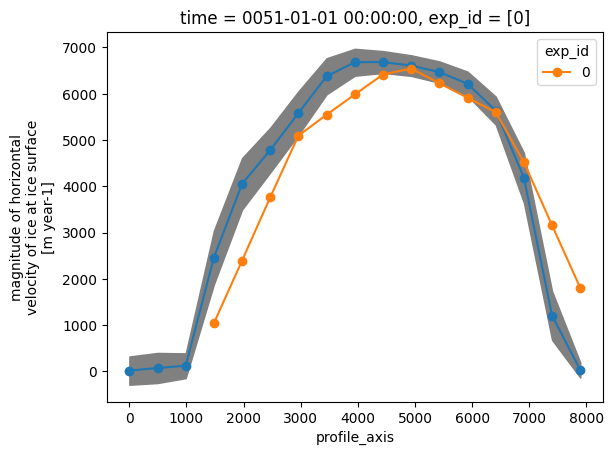

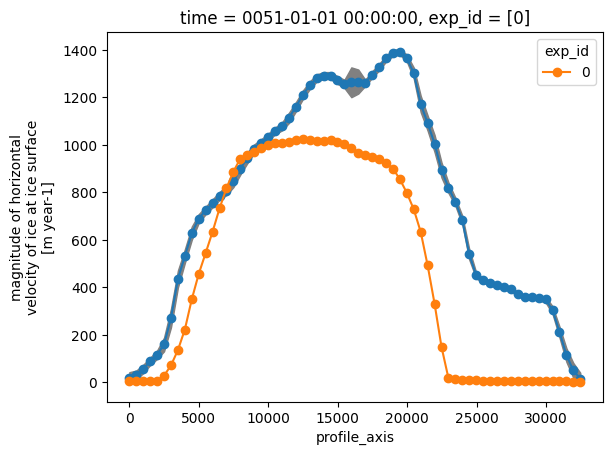

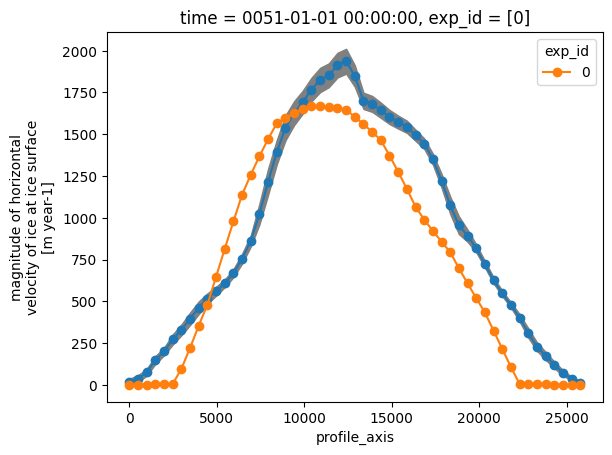

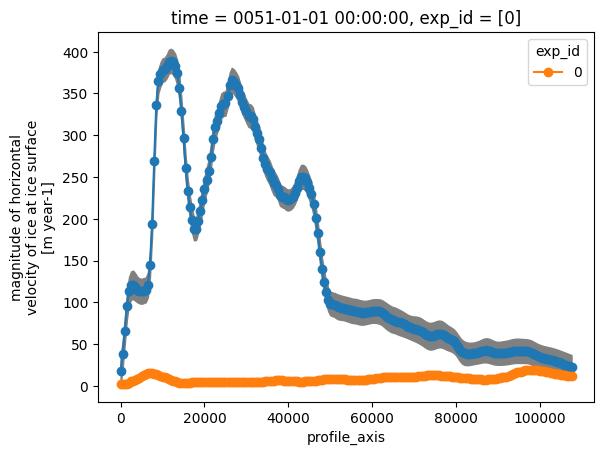

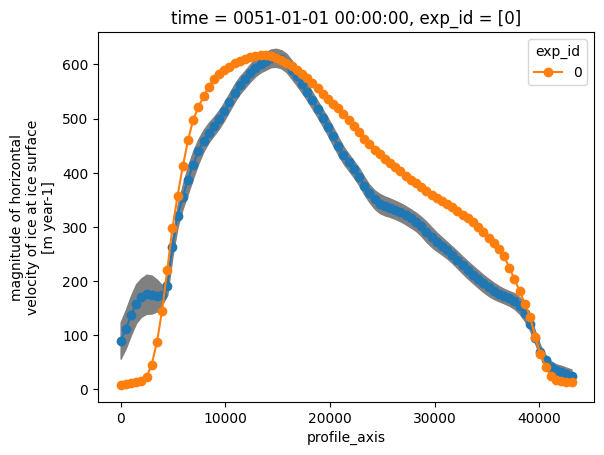

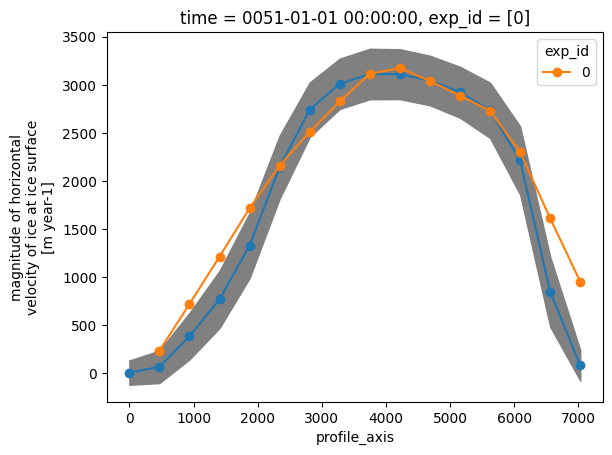

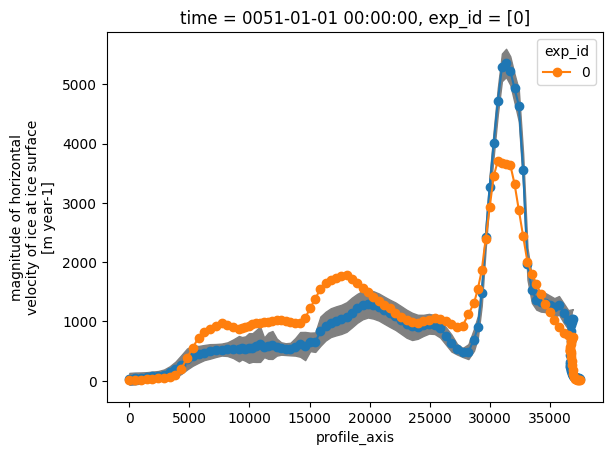

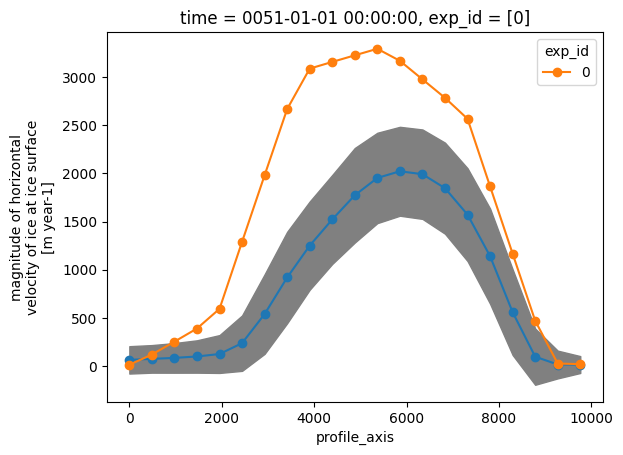

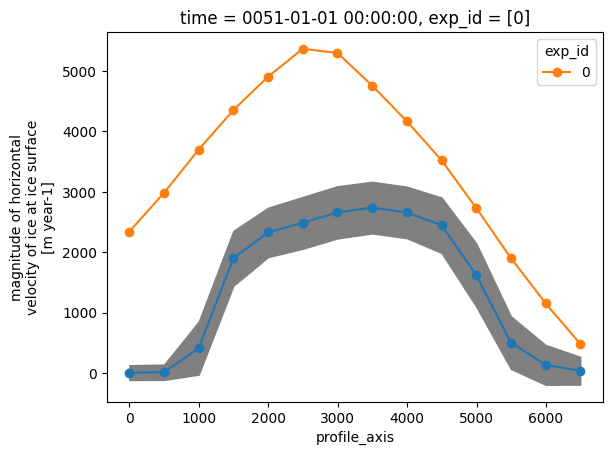

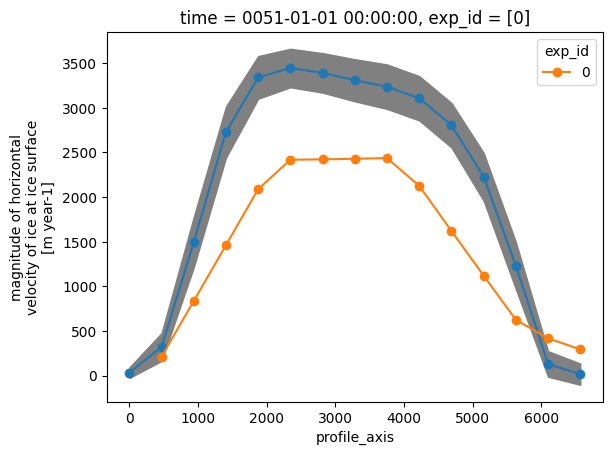

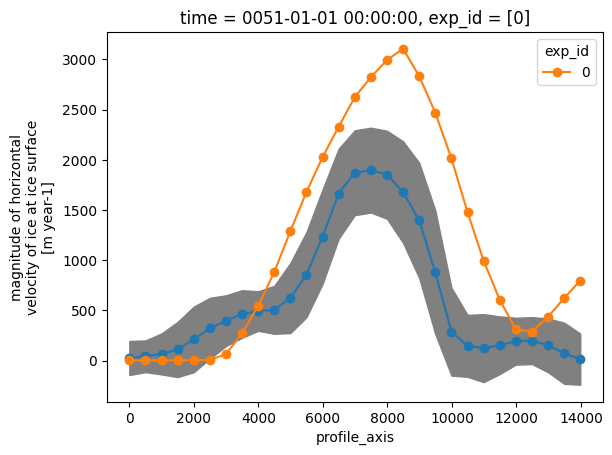

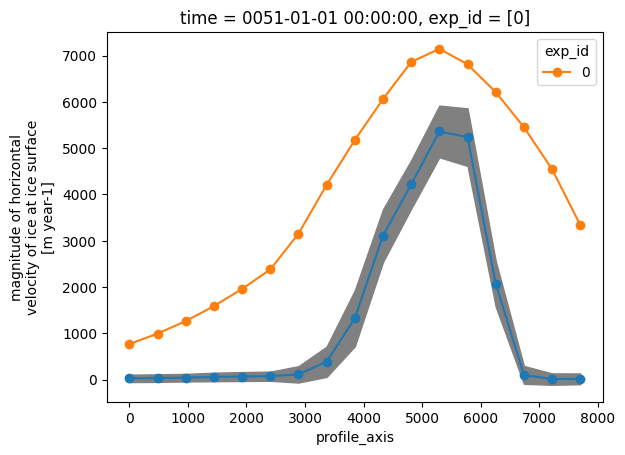

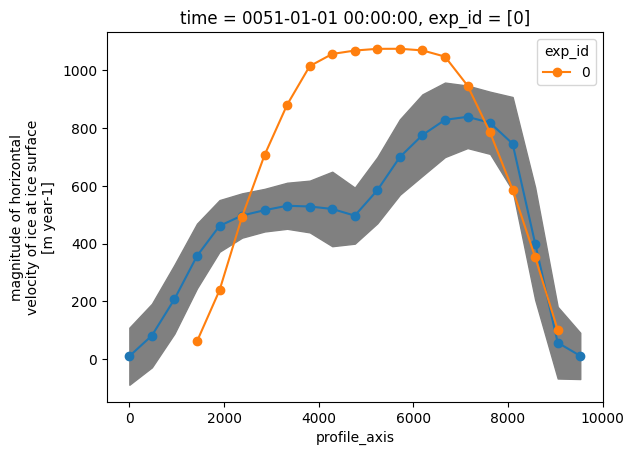

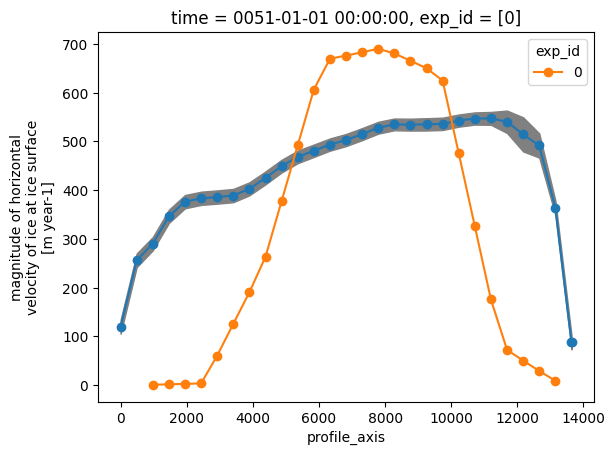

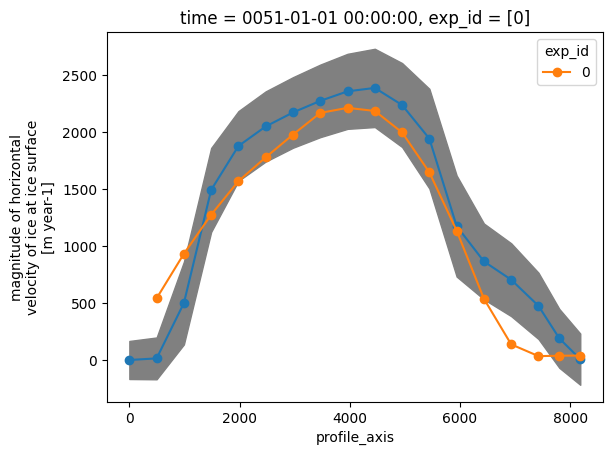

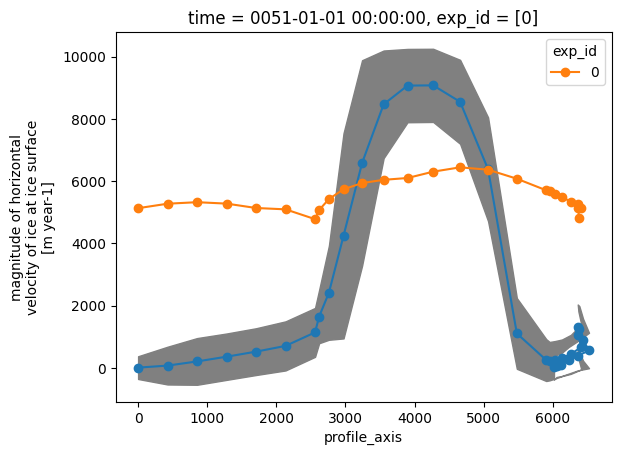

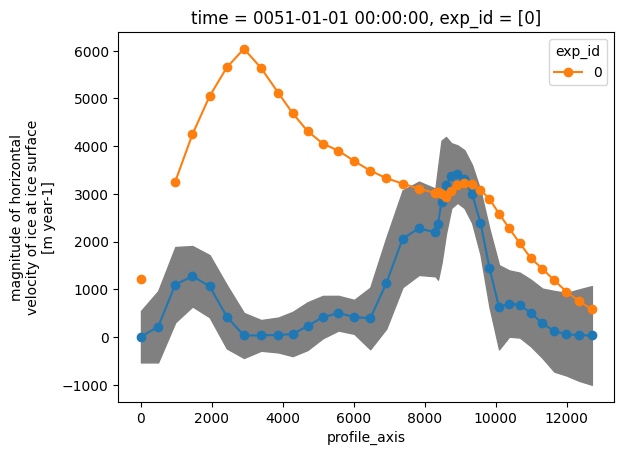

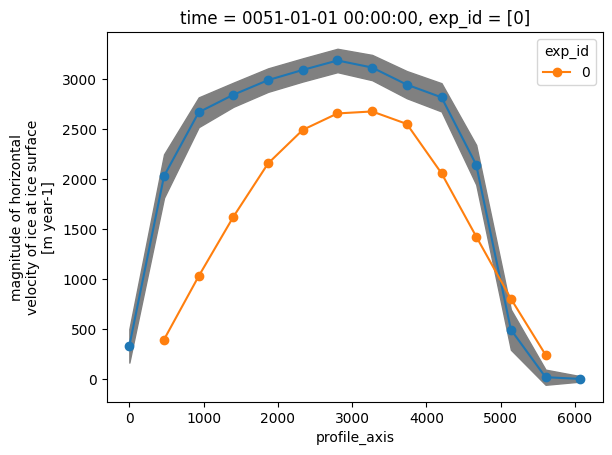

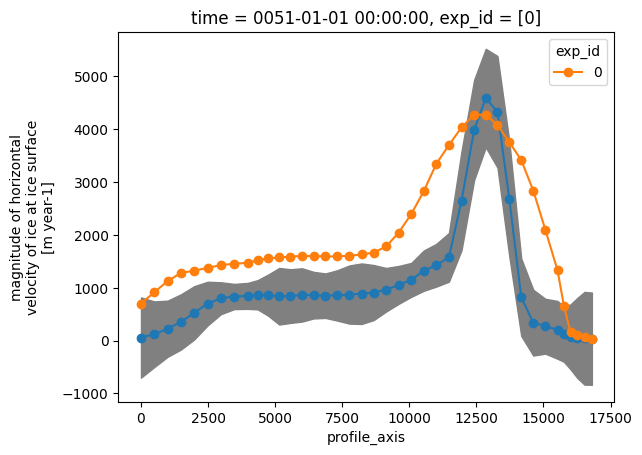

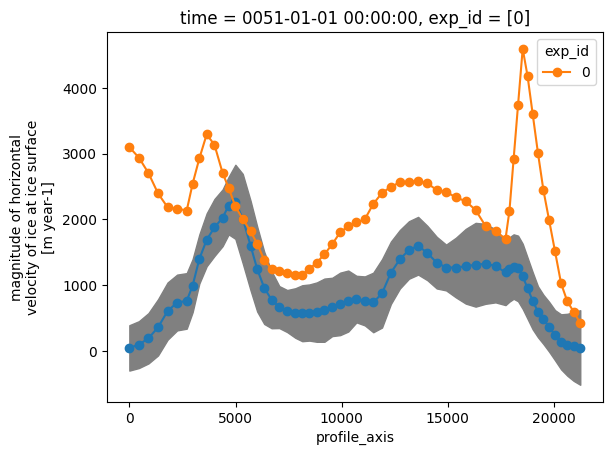

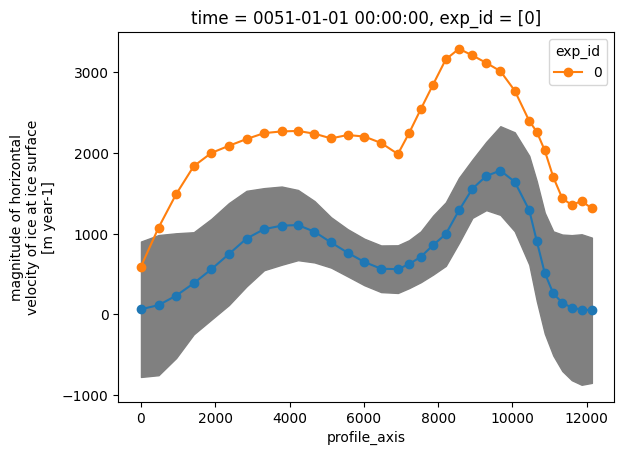

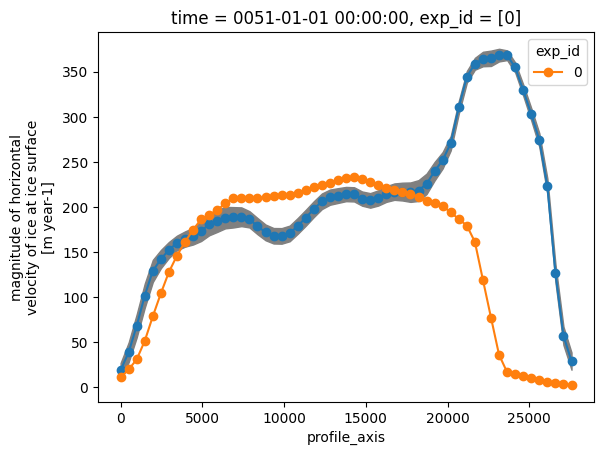

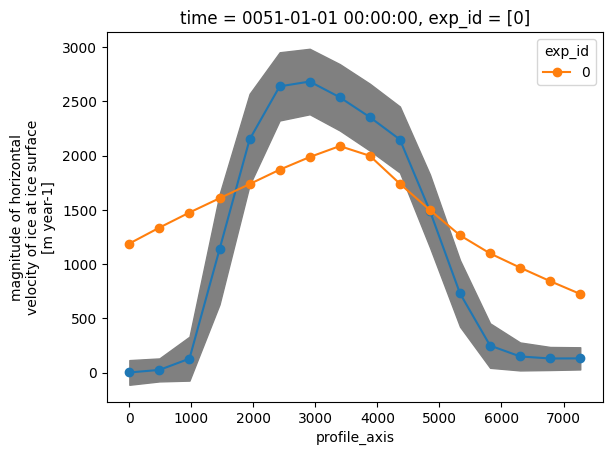

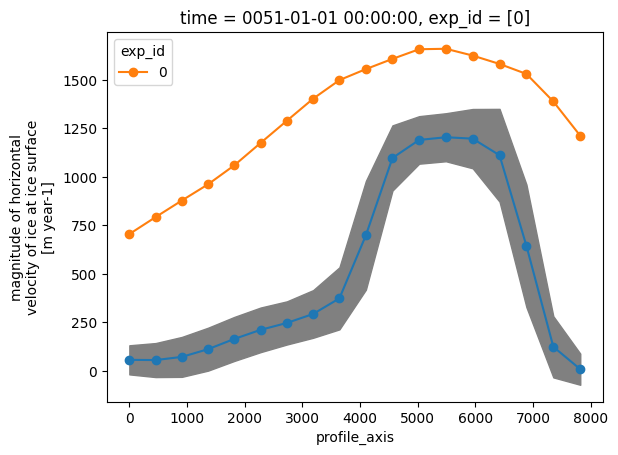

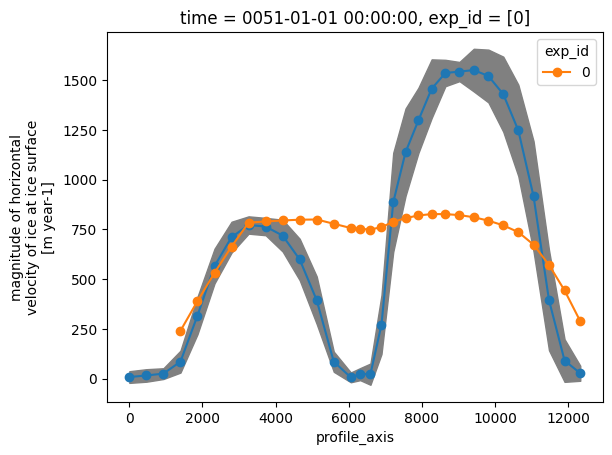

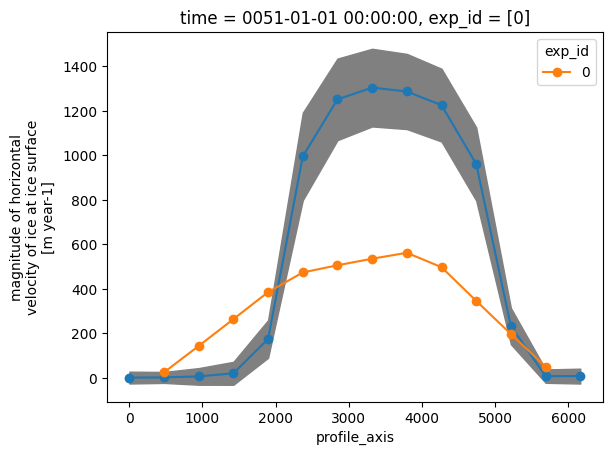

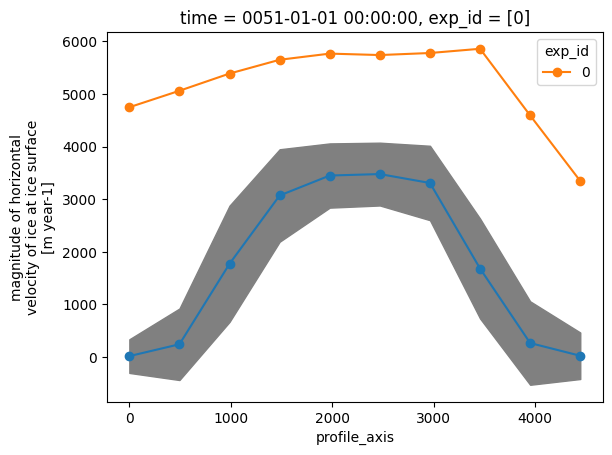

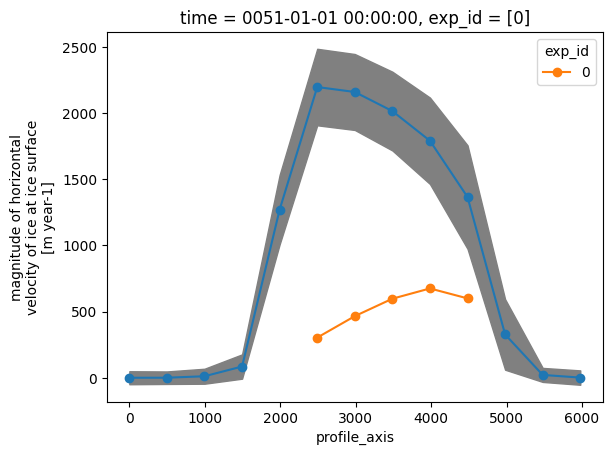

In [37]:
sims_profiles = []
obs_profiles = []
sigma = 100
for p, profile in profiles_gp.iterrows():
    x, y = profile["geometry"].xy
    x = np.asarray(x)
    y = np.asarray(y)
    sims_profile = extract_profile(sim_ds, x, y).chunk()
    obs_profile = extract_profile(obs_ds, x, y)
    obs_profile = obs_profile.profiles.add_normal_component().chunk()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.fill_between(obs_profile["profile_axis"], obs_profile["v"] - sigma * obs_profile["v_err"], 
                    obs_profile["v"] + sigma * obs_profile["v_err"], color="0.5")
    obs_profile["v"].plot.line(x="profile_axis", marker="o", ax=ax)
    sims_profile["velsurf_mag"].isel(time=0).plot.line(x="profile_axis", marker="o", ax=ax)
    obs_profile = obs_profile.expand_dims(dim="profile")
    obs_profile["profile_id"] = [p]
    obs_profiles.append(obs_profile)
    sims_profile = sims_profile.expand_dims(dim="profile_id")
    sims_profile["profile_id"] = [p]
    sims_profiles.append(sims_profile)
    
    o = obs_profile["v"]
    s = sims_profile.isel(time=0, exp_id=0)["velsurf_mag"]
    #print(xr.corr(o, s).to_numpy())

In [9]:
# @xr.register_dataset_accessor('profiles')
# class CustomDatasetMethods:
#     """
#     Custom methods for xarray Dataset.
#     """
#     def __init__(self, xarray_obj: xr.Dataset):
#         self._obj = xarray_obj

#     def add_normal_component(self, x_component: str = "vx", y_component: str = "vy", normal_name: str = "v_normal") -> xr.Dataset:
#         """
#         Add a normal component to the dataset.
#         """
#         assert x_component in self._obj.data_vars and y_component in self._obj.data_vars, \
#             f"Both {x_component} and {y_component} must be in the dataset's data_vars."

#         func = lambda x, x_n,  y, y_n: x * x_n + y * y_n
#         self._obj[normal_name] = xr.apply_ufunc(func, self._obj[x_component], self._obj["nx"], self._obj[y_component], self._obj["ny"])
        
#         return self._obj

In [10]:

obs_profile.profiles.add_normal_component()

<xarray.Dataset>
Dimensions:        (profile_axis: 13, profile: 1)
Coordinates:
  * profile_axis   (profile_axis) float64 0.0 498.0 ... 5.478e+03 5.976e+03
    x              (profile_axis) float64 -1.941e+05 -1.938e+05 ... -1.905e+05
    y              (profile_axis) float64 -3.084e+06 -3.085e+06 ... -3.089e+06
  * profile        (profile) int64 27
Data variables: (12/14)
    nx             (profile, profile_axis) float64 0.7951 0.7951 ... 0.7951
    ny             (profile, profile_axis) float64 0.6065 0.6065 ... 0.6065
    vx             (profile, profile_axis) float64 0.1854 0.2934 ... 15.9 1.353
    vy             (profile, profile_axis) float64 -0.2843 -0.5701 ... -0.256
    v              (profile, profile_axis) float64 0.3404 0.6413 ... 21.71 1.518
    vx_err         (profile, profile_axis) float64 0.3828 0.3832 ... 0.4376
    ...             ...
    count          (profile, profile_axis) float64 2.876e+03 ... 2.498e+03
    chip_size_max  (profile, profile_axis) float64 592.4 480.0 ... 480.0 480.0
    ocean          (profile, profile_axis) float64 nan nan nan ... nan nan nan
    rock           (profile, profile_axis) float64 1.0 1.0 1.0 ... nan nan 1.0
    ice            (profile, profile_axis) float64 nan nan nan ... 1.0 nan nan
    v_normal       (profile, profile_axis) float64 -0.02502 -0.1125 ... 0.9208

In [15]:
sims_profile

<xarray.Dataset>
Dimensions:                                                     (
                                                                 profile_axis: 17,
                                                                 time: 1,
                                                                 exp_id: 1,
                                                                 zb: 21, z: 201)
Coordinates:
  * profile_axis                                                (profile_axis) float64 ...
  * time                                                        (time) object ...
    lat                                                         (profile_axis) float64 dask.array<chunksize=(17,), meta=np.ndarray>
    lon                                                         (profile_axis) float64 dask.array<chunksize=(17,), meta=np.ndarray>
  * exp_id                                                      (exp_id) int64 0
    x                                                           (profile_axis) float64 ...
    y                                                           (profile_axis) float64 ...
  * zb                                                          (zb) float64 ...
  * z                                                           (z) float64 0...
Data variables: (12/46)
    nx                                                          (profile_axis) float64 ...
    ny                                                          (profile_axis) float64 ...
    thk                                                         (exp_id, time, profile_axis) float64 dask.array<chunksize=(1, 1, 17), meta=np.ndarray>
    ice_area_specific_volume                                    (exp_id, time, profile_axis) float64 dask.array<chunksize=(1, 1, 17), meta=np.ndarray>
    vel_bc_mask                                                 (exp_id, profile_axis) float64 dask.array<chunksize=(1, 17), meta=np.ndarray>
    u_bc                                                        (exp_id, time, profile_axis) float64 dask.array<chunksize=(1, 1, 17), meta=np.ndarray>
    ...                                                          ...
    sftgif                                                      (exp_id, time, profile_axis) float32 dask.array<chunksize=(1, 1, 17), meta=np.ndarray>
    tempicethk_basal                                            (exp_id, time, profile_axis) float32 dask.array<chunksize=(1, 1, 17), meta=np.ndarray>
    velbase_mag                                                 (exp_id, time, profile_axis) float32 dask.array<chunksize=(1, 1, 17), meta=np.ndarray>
    uvelsurf                                                    (exp_id, time, profile_axis) float32 dask.array<chunksize=(1, 1, 17), meta=np.ndarray>
    vvelsurf                                                    (exp_id, time, profile_axis) float32 dask.array<chunksize=(1, 1, 17), meta=np.ndarray>
    velsurf_mag                                                 (exp_id, time, profile_axis) float32 dask.array<chunksize=(1, 1, 17), meta=np.ndarray>

In [12]:
def normal(point0: np.ndarray, point1: np.ndarray) -> np.ndarray:
    """Compute the unit normal vector orthogonal to (point1-point0),
    pointing 'to the right' of (point1-point0).

    """

    a = point0 - point1
    if a[1] != 0.0:
        n = np.array([1.0, -a[0] / a[1]])
        n = n / np.linalg.norm(n)  # normalize
    else:
        n = np.array([0, 1])

    # flip direction if needed:
    if np.cross(a, n) < 0:
        n = -1.0 * n

    return n

def compute_normals(px, py):
    """
    Compute normals to a profile described by 'p'. Normals point 'to
    the right' of the path.
    """

    p = np.vstack((px, py)).T

    if len(p) < 2:
        return [0], [0]

    ns = np.zeros_like(p)
    ns[0] = normal(p[0], p[1])
    for j in range(1, len(p) - 1):
        ns[j] = normal(p[j - 1], p[j + 1])

    ns[-1] = normal(p[-2], p[-1])

    return ns[:, 0], ns[:, 1]


In [13]:
compute_normals(ds["x"], ds["y"])

NameError: name 'ds' is not defined

In [ ]:
profile.geometry

In [ ]:
    ds = obs_ds
    x, y = profile["geometry"].xy
    x = np.asarray(x)
    y = np.asarray(y)
    if "profile_axis" in profile:
        profile_axis = profile["profile_axis"]
    else:
        profile_axis = np.sqrt((x-x[0])**2 + (y-y[0])**2)
    x = xr.DataArray(x, dims="profile_axis", coords={"profile_axis": profile_axis})
    y = xr.DataArray(y, dims="profile_axis", coords={"profile_axis": profile_axis})
    aux_vars = ["nx", "ny"]
    
    das = [xr.DataArray(profile[aux_var], dims="profile_axis", coords={"profile_axis": profile_axis}, name=aux_var) for aux_var in aux_vars]
    ds.interp(x=x, y=y, kwargs={"fill_value": np.nan}, method_non_numeric="bfill")


In [ ]:
sim_ds["velsurf_mag"]

In [ ]:
x

In [ ]:
obs_ds.isel(x=[0, 1, 2], y=[0, 1, 2]).to_dict()

In [ ]:
xr.merge(obs_profiles, compat="broadcast_equals")

In [ ]:
import pandas as pd

In [ ]:
d = pd.concat([df.to_dataframe() for df in obs_profiles]).reset_index()

In [ ]:
df = obs_profile.to_dataframe()
gp.GeoDataFrame(geometry=[[df["x"].to_numpy().T], [df["y"].to_numpy().T]])

In [ ]:
sims_profile.chunk()

In [ ]:
oo = obs_profile.expand_dims(dim="profile")
oo["profile"] = [0]

In [ ]:
gp.GeoDataFrame?

In [ ]:
obs_profile["geom"]

In [60]:
ss = dask_geopandas.from_geopandas(profiles_gp, npartitions=13)

In [65]:
obs = pd.concat([pd.merge(profiles_gp, op.to_dataframe().reset_index(), left_on="id", right_on="profile_id") for op in obs_profiles])
sims = pd.concat([pd.merge(profiles_gp, sim.to_dataframe().reset_index(), left_on="id", right_on="profile_id") for sim in sims_profiles])

In [49]:
import dask.dataframe as dd

In [ ]:
obs_profile.to_dataframe().reset_index()

In [69]:
%timeit pd.concat([dd.merge(profiles_gp, op.to_dataframe().reset_index(), left_on="id", right_on="profile_id") for op in obs_profiles])


294 ms ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
%timeit pd.concat([dd.merge(profiles_gp, sim.to_dataframe().reset_index(), left_on="id", right_on="profile_id") for sim in sims_profiles])

8.91 s ± 66.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
dgp_sims = dask_geopandas.from_geopandas(sims, npartitions=13)
dgp_sims.geometry.area.compute(

Type:        property
String form: <property object at 0x382242520>
Docstring:   <no docstring>

In [77]:
g = dgp_sims.geometry

In [84]:
%timeit sims.geometry.length

163 ms ± 627 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
%timeit g.length.compute()

36.6 ms ± 551 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
pd.merge(profiles_gp, sims_profiles[1].to_dataframe().reset_index(), left_on="id", right_on="profile")

In [ ]:
"id" in sims_profiles[1].to_dataframe().reset_index()